# Neural Networks for Eddy Covarinace

In [164]:
## Import some standard packages and define a few functions

import time
import importlib
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs
dbNames = {
    'Clean/SecondStage/TA_1_1_1':'Ta',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/P_1_1_1':'P',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'USTAR',
    'Clean/SecondStage/TS_1':'TS_1'
}

read_new = False
if read_new == True:
    Data = ReadDB.get_Traces('BB',list(dbNames.keys()),Dir='/mnt/w/')
    Data = Data.rename(columns=dbNames)
    Data.to_csv('temp/BB1_VPD.csv')

else:
    Data = pd.read_csv('temp/BB1_VPD.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')

# Data = Data.dropna(axis=0)
Data['VPD'] = MiscFuncs.Calc_VPD(Data['Ta'],Data['RH'])
Data['DOY'] = Data.index.dayofyear
Data.describe()

,Ta,RH,FCO2,FCH4,PPFD,P,qc_FCO2,qc_FCH4,USTAR,TS_1,VPD,DOY
count,145980.000000,145835.000000,40106.000000,45601.000000,157776.000000,145727.000000,96257.000000,78180.000000,76140.000000,143777.000000,145835.000000,157776.000000
mean,10.430474,84.263737,-0.289915,50.067435,196.090986,0.070240,0.842422,0.680455,0.165426,11.496792,2.774662,183.111348
std,6.890757,15.496817,4.175810,68.879458,351.702081,0.293557,0.759811,0.743985,0.115342,5.343971,3.892272,105.430923
min,-13.752307,0.000000,-49.348000,-199.917200,-4.483798,0.000000,0.000000,0.000000,0.000275,-23.012709,-0.016805,1.000000
25%,5.775461,75.057063,-1.566764,8.250704,0.002712,0.000000,0.000000,0.000000,0.071127,6.580817,0.326642,92.000000
50%,10.007422,89.691050,-0.033443,29.992270,3.392855,0.000000,1.000000,1.000000,0.140676,11.260803,1.202624,183.000000
75%,15.013435,96.623552,0.718964,86.221634,225.841945,0.000000,1.000000,1.000000,0.236807,16.561434,3.629304,274.000000
max,38.048030,100.194626,49.777348,695.056900,1883.940900,11.500000,2.000000,2.000000,2.625967,24.228456,42.408361,366.000000


In [170]:
importlib.reload(ReadDB)

inputs = ['PPFD','Junk','TS_1','Const']
target = ['FCO2']

Data['Junk']=np.random.random(Data['FCO2'].values.shape)
Data['Const']=Data['Junk']*0+1

print(Data[['FCO2']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.rain('P',thresh=1)
filter.MAD(z=7)
filter.uStar('USTAR')
Data = filter.df.copy()
Data = Data.loc[Data[target+inputs].dropna().index].copy()
print(Data[['FCO2']].describe())
print(Data.shape)

from sklearn.preprocessing import StandardScaler
Norm = StandardScaler()


NormInputs = [f'{ip}_norm' for ip in inputs]


Norm.fit(Data[inputs])
Data[NormInputs] = Norm.transform(Data[inputs])


               FCO2
count  16147.000000
mean      -0.735815
std        1.525492
min       -3.734053
25%       -1.951628
50%       -0.692962
75%        0.410743
max        3.884488
               FCO2
count  16147.000000
mean      -0.735815
std        1.525492
min       -3.734053
25%       -1.951628
50%       -0.692962
75%        0.410743
max        3.884488
(16147, 14)


# Format the training data

In [171]:
# Randomly Drop 25% of the data - use those points for model validation
Training,Validation = MiscFuncs.makeMask(Data,target,dropOut=.25)

Examples = {
    'Full':{
        'X_train':Training[NormInputs].values,
        'Y_train':Training[target].values.flatten(),
        'X_val':Validation[NormInputs].values,
        'Y_val':Validation[target].values.flatten(),
            },
}

print(Examples['Full']['Y_train'].shape)
print(Examples['Full']['Y_val'].shape)

(12110,)
(4037,)


In [172]:

importlib.reload(NNetFuncs)

Set = 'Full'

NNetFuncs.make_SHL_model(input_shape=Examples[Set]['X_train'].shape[1])

T1 = time.time()
NNetFuncs.train_model(Examples[Set]['X_train'],
                      Examples[Set]['Y_train'],
                      Sub_Models=3
                      )

T2 = time.time()
print(f'Complted Training in: {T2-T1} seconds')

Model: "SHL_NN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Complted Training in: 120.96202540397644 seconds


['PPFD', 'Junk', 'TS_1', 'Const']
0.8296762531698302
[0.87117593 0.8050475  0.81543214 0.81347654]


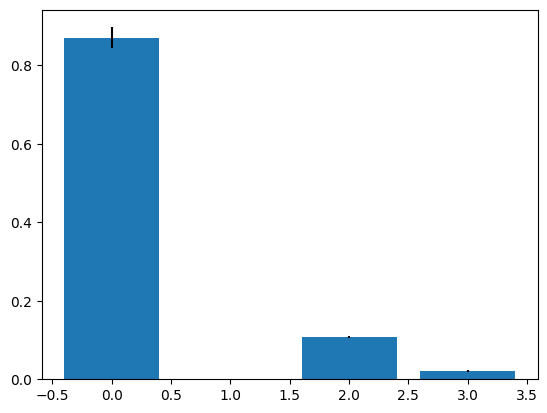

In [173]:
print(inputs)

importlib.reload(NNetFuncs)

RI,out_dx = NNetFuncs.predict_Model(Examples[Set]['X_train'],Examples[Set]['Y_train'])



print(metrics.r2_score(out_dx['target'],out_dx['y_bar']))

# fig,ax=plt.subplots()
# dx='x0'
# ax.scatter(out_dx[f'{dx}'],out_dx[f'dy_d{dx}'])
# ax.set_yscale('symlog')
# ax.plot(out_dx[f'{dx}'],out_dx[f'{dx}']*0,color='k')

fig,ax=plt.subplots()
ax.bar(RI.index,RI['RI'],yerr=RI['RI_95'])

stand = StandardScaler()

stand.fit(out_dx[['dy_dx0','dy_dx1','dy_dx2','dy_dx3']])

T = stand.transform(out_dx[['dy_dx0','dy_dx1','dy_dx2','dy_dx3']])

print((np.abs(T)).mean(axis=0))

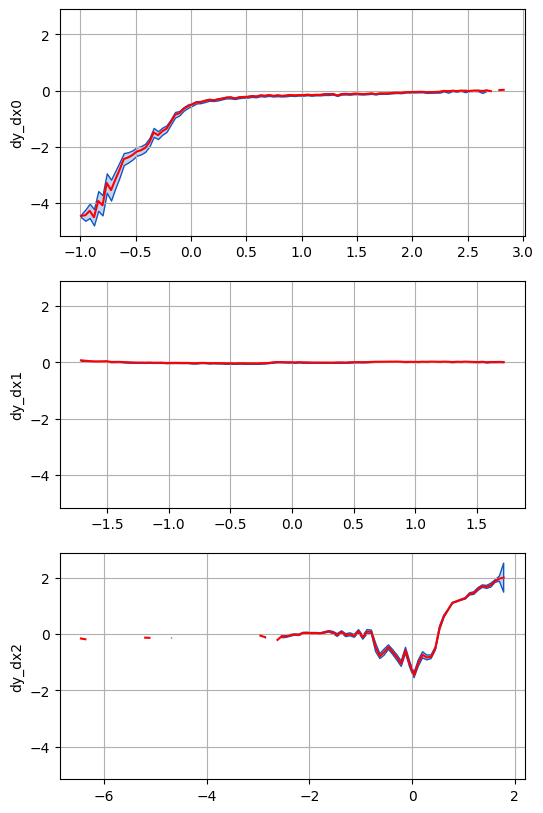

In [181]:
# out_dx
from Scripts import PlotHelpers
importlib.reload(PlotHelpers)
importlib.reload(MiscFuncs)

npi=3
fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

for i in range(npi):
    df = MiscFuncs.byInterval(out_dx,f'x{i}',[f'dy_dx{i}'],bins=100)
    PlotHelpers.CI_Plot(axes[i],df,f'dy_dx{i}')
    # axes[i].scatter(out_dx[f'x{i}'],out_dx[f'dy_dx{i}'])
# out_dx

# pd.cut(out_dx[f'x{0}'],bins=100)

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
import json
import os
from os import walk
import ipywidgets as widgets


def make_model(input_shape,hidden_nodes,name='Model'):
    try:
        os.mkdir("temp_files/"+name)
    except:
        clean_dir(name)
    input_layer = keras.layers.Input(input_shape)
    dense1 = keras.layers.Dense(
                                hidden_nodes,
                                activation='relu',
                                kernel_initializer="glorot_uniform",
                                bias_initializer="zeros"
                                )(input_layer)
    output_layer = keras.layers.Dense(1)(dense1)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer,name=name)
    print(model.summary())
    model_json = model.to_json()
    with open(f"temp_files/{name}/model_architecture.json", "w") as json_file:
        json_file.write(model_json)

def train_model(x,y,i=0,name='Model',epochs = 250,batch_size = 32): 

    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        model = model_from_json(json.dumps(architecture))

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"temp_files/{name}/model_weights"+str(i)+".h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=0),
    ]

    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

    model.fit(
        x,
        y,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )

    tf.keras.backend.clear_session()

def predict_Model(name,N,x):

    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        loaded_model = model_from_json(json.dumps(architecture))

    pred = []
    for i in range(N):
        loaded_model.load_weights(f"temp_files/{name}/model_weights"+str(i)+".h5")
        loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        
        pred.append(loaded_model.predict(x))
    return(np.array(pred))


def Get_Weights(name, N):
    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        # print(architecture)
        loaded_model = model_from_json(json.dumps(architecture))

    # Input layer
    W_i = []
    # Transposed Input layer
    W_i_T = []
    # Dense Input Layer
    W_d_i = []
    # Dense Output Layer
    W_d_o = []
    # Transposed Dense Output Layer
    W_d_o_T = []
    # Output Layer
    W_o = []

    for i in range(N):
        loaded_model.load_weights(f"temp_files/{name}/model_weights"+str(i)+".h5")
        W = loaded_model.get_weights()
        W_i.append(W[0])
        W_i_T.append(W[0].T)
        W_d_i.append(W[1])
        W_d_o.append(W[2])
        W_d_o_T.append(W[2].T)
        W_o.append(W[3])
    W_i = np.array(W_i)
    # W_i_T = np.array(W_i_T)
    W_d_i = np.array(W_d_i)
    W_d_o = np.array(W_d_o)
    # W_d_o_T = np.array(W_d_o_T)
    W_o = np.array(W_o)
    return(W_i,W_d_i,W_d_o,W_o)   

def get_Derivatives(name,N_models,X,y):
    W_i,W_d_i,W_d_o,W_o = Get_Weights(name,N_models)
    Op = []
    # print(np.dot(X,W_i[0])+W_d_i[0])
    # H1 = np.array([np.dot(X,W_i[x])+W_d_i[x] for x in range(W_i.shape[0])])
    # print(H1.shape)
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = np.array([np.dot(Ip,W_i[x])+W_d_i[x] for x in range(W_i.shape[0])])
        # The relu activation function
        # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
        H1 = np.maximum(H1,np.zeros(H1.shape))
        H2 = np.array([np.dot(H1[x],W_d_o[x])+W_o[x] for x in range(W_d_o.shape[0])])
        Op.append(H2)
    Estimates = np.array(Op)
    SSD = []
    SAD = []
    Derivs = []
    for i in range(X.shape[1]):
        dj=[]
        for j in range(y.shape[0]):
            target = y[j]
            Xj = X[j][i]
            if np.isnan(target)==False:
                # print(W_i.shape)
                H1 = np.array([np.dot(Xj,W_i[x,i])+W_d_i[x] for x in range(W_i.shape[0])])
                # The relu activation function
                # If using Sigmoid function, change to - DH1 = H1/(1-H1)
                DH1 = np.maximum(H1,np.zeros(H1.shape))
                DH1[DH1>0]=1
                DH2 = (W_d_o[:,:,0]*DH1*W_i[:,i,:]).sum(axis=-1)
                # print(DH2.shape,DH2)
                DH2 = np.array([(W_d_o[x,:,0]*DH1[x]*W_i[x,i,:])for x in range(W_d_o.shape[0])]).sum(axis=-1)
                # DH2 = np.array([(DH1[x]*W_d_o[x])+W_o[x] for x in range(W_d_o.shape[0])])
                # print(DH2.shape,DH2)
                # print()

                # DH2 = np.array([np.dot(DH1[x],W_d_o[x])+W_o[x] for x in range(W_d_o.shape[0])])
                Sj = 1
                dj.append(Sj*DH2)
        dji = np.array(dj)
        Derivs.append(dji)
        SSD.append(np.sum(dji**2,axis=0))
        SAD.append(np.sum(np.abs(dji),axis=0))
    Derivs = np.array(Derivs)
    SSD = np.array(SSD)
    RI_SSD = SSD/SSD.sum(axis=0)
    SAD = np.array(SAD)
    RI_SAD = SAD/SAD.sum(axis=0)
    return(RI_SSD,RI_SAD,Derivs,Estimates)

## Training the NN models 

* Training is also considerably slower
    * This model is being run on a GPU which helps speed things up.  It can be run on a system without a suitable GPD, but processing on a CPU alone is **much slower**

    * Ensembling increases accuracy but also increases training time.  This example uses an ensemble of N=10 randomly initialized networks trained the same randomly split training data as the RF model.
        * In practice its better to use different random splits for each model in the ensemble or use a systematic splitting method.  We use the same random split as the RF model here for a more direct comparison.


In [14]:
N_models = 3
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=N_models,
    step=1,
    description='Training:',
    orientation='horizontal'
)
display(progress)

print('Test the Full Dataset')

# Leaving random state fixed here for more direct comparison with RF results
# In practice, it is better to train each model on separate splits
x_train, x_val, y_train, y_val = train_test_split(
    X_full,Y_full, test_size=0.1, random_state=42) 

make_model(input_shape=X_full.shape[1:],hidden_nodes=64)

T1 = time.time()
y_est,y_obs = [],[]
for i in range(N_models):
    progress.value=i
    train_model(x_train,y_train,i)
T2 = time.time()
progress.value=N_models
print('\nFull Training Time: ', np.round((T2 - T1)/60,2),' Minutes')
print('\nTime: Per Model', np.round((T2 - T1)/N_models,2),' Seconds')

print()
print()
print('Test the Masked Dataset')


# Leaving random state fixed here for more direct comparison with RF results
# In practice, it is better to train each model on separate splits
x_train, x_val_mask, y_train, y_val_mask = train_test_split(
    x_mask,y_mask, test_size=0.1, random_state=42) 

make_model(input_shape=x_mask.shape[1:],hidden_nodes=64,name='Masked_Model')

T1 = time.time()
y_est,y_obs = [],[]
for i in range(N_models):
    progress.value=i
    train_model(x_train,y_train,i,name='Masked_Model')
T2 = time.time()
progress.value=N_models
print('\nFull Training Time: ', np.round((T2 - T1)/60,2),' Minutes')
print('\nTime: Per Model', np.round((T2 - T1)/N_models,2),' Seconds')


IntProgress(value=0, description='Training:', max=3)

Test the Full Dataset
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2023-04-24 17:25:24.478684: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Full Training Time:  4.49  Minutes

Time: Per Model 89.76  Seconds


Test the Masked Dataset
Model: "Masked_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None

Full Training Time:  3.38  Minutes

Time: Per Model 67.57  Seconds


(2500, 2)


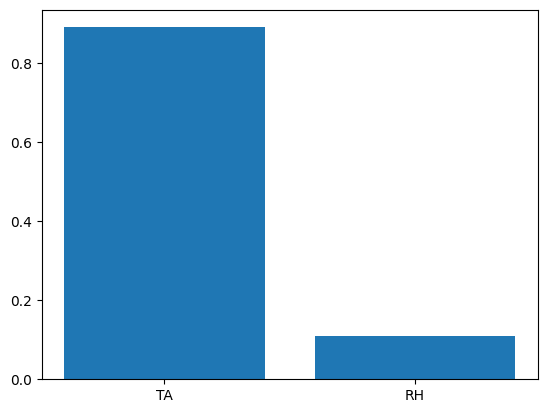

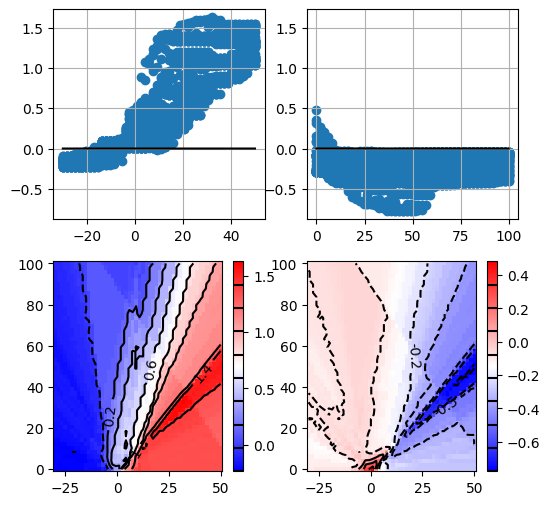

In [15]:

def get_Tape(name,N_models,X):
    
    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        # print(architecture)
        loaded_model = model_from_json(json.dumps(architecture))

    X_tensor = tf.convert_to_tensor(X)
    dy_dx = []
    y_pred = []
    for i in range(N_models):
        loaded_model.load_weights(f"temp_files/{name}/model_weights"+str(i)+".h5")
            
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X_tensor)
            
            # Forward pass.
            est = loaded_model(X_tensor)
            y_pred.append(est)

        # Get gradients of the pred wrt x
        dy_dx.append(tape.gradient(est,X_tensor))
    dy_dx = np.array(dy_dx)
    y_pred = np.array(y_pred)
    return(y_pred,dy_dx)

y_pred, dy_dx = get_Tape('Model',N_models,range_TA_RH.T)

print(dy_dx.mean(axis=0).shape)

SSD = (dy_dx.mean(axis=0)**2).sum(axis=0)

plt.figure()
plt.bar(['TA','RH'],SSD/SSD.sum(axis=0))

dVPD_dTA = dy_dx.mean(axis=0)[:,0]
dVPD_dRH = dy_dx.mean(axis=0)[:,1]


NN_grid_VPD = y_pred.mean(axis=0).T.reshape(grid_TA.shape)
NN_grid_dVPD_dTA = dy_dx[:,:,0].mean(axis=0).T.reshape(grid_TA.shape)
NN_grid_dVPD_dRH = dy_dx[:,:,1].mean(axis=0).T.reshape(grid_TA.shape)

fig,axes=plt.subplots(2,2,figsize=(6,6))#,sharey='col',sharex='col')
ax=axes[0,0]
ax.scatter(range_TA_RH.T[:,0],dVPD_dTA)
ax.plot(range_TA_RH.T[:,0],dVPD_dTA*0,color='k')
ax.set_ylim(dy_dx.mean(axis=0).min()-.1,dy_dx.mean(axis=0).max()+.1)
ax.grid()

ax=axes[0,1]
ax.scatter(range_TA_RH.T[:,1],dVPD_dRH)
ax.plot(range_TA_RH.T[:,1],dVPD_dRH*0,color='k')
ax.set_ylim(dy_dx.mean(axis=0).min()-.1,dy_dx.mean(axis=0).max()+.1)
ax.grid()

ax=axes[1,0]
Contour_Plot(ax,grid_TA,grid_RH,NN_grid_dVPD_dTA)

ax=axes[1,1]
Contour_Plot(ax,grid_TA,grid_RH,NN_grid_dVPD_dRH)#,cmap = cmap,norm=norm,unit=unit,bins=bins)
# plt.imshow()


tf.Tensor(
[[ 0.04826833 -0.00509393]
 [ 0.05541632 -0.00593915]
 [ 0.06348165 -0.00690843]
 ...
 [ 0.         -1.05348719]
 [ 0.         -1.14433363]
 [ 0.         -1.24186081]], shape=(2500, 2), dtype=float64)


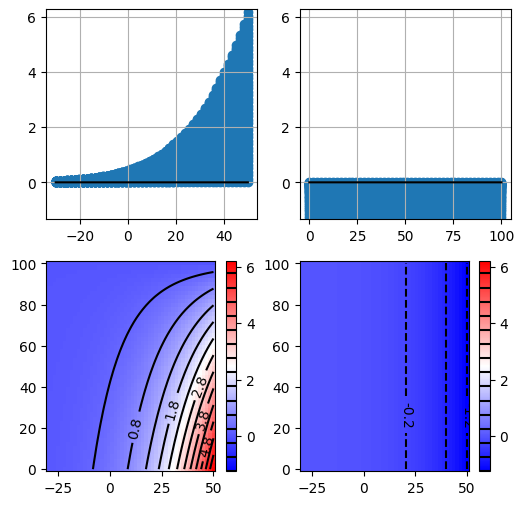

In [16]:

def Calc_VPD_tf(X):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*tf.exp((17.502*X[:,0])/(240.97+X[:,0]))
    e_H = X[:,1]*ea_H/100
    VPD = (ea_H - e_H)*10
    return (VPD)

X_tensor = tf.convert_to_tensor(range_TA_RH.T)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(X_tensor)
    est = Calc_VPD_tf(X_tensor) 

# Get gradients of the pred wrt x
Deriv = tape.gradient(est,X_tensor)
print(Deriv)


Actual_dVPD_dTA = Deriv.numpy()[:,0]
Actual_dVPD_dRH = Deriv.numpy()[:,1]


Actual_grid_VPD = est.numpy().T.reshape(grid_TA.shape)
Actual_grid_dVPD_dTA = Deriv[:,0].numpy().T.reshape(grid_TA.shape)
Actual_grid_dVPD_dRH = Deriv[:,1].numpy().T.reshape(grid_TA.shape)


fig,axes=plt.subplots(2,2,figsize=(6,6))
ax=axes[0,0]
ax.scatter(range_TA_RH.T[:,0],Actual_dVPD_dTA)
ax.plot(range_TA_RH.T[:,0],Actual_dVPD_dTA*0,color='k')
ax.set_ylim(Deriv.numpy().min()-.1,Deriv.numpy().max()+.1)
ax.grid()

ax=axes[0,1]
ax.scatter(range_TA_RH.T[:,1],Actual_dVPD_dRH)
ax.plot(range_TA_RH.T[:,1],Actual_dVPD_dRH*0,color='k')
ax.set_ylim(Deriv.numpy().min()-.1,Deriv.numpy().max()+.1)
ax.grid()


d_bins = np.arange(Deriv.numpy().min(),Deriv.numpy().max(),.5)

d_norm = Normalize(vmin=Deriv.numpy().min(), vmax=Deriv.numpy().max(), clip=False)


ax=axes[1,0]
Contour_Plot(ax,grid_TA,grid_RH,Actual_grid_dVPD_dTA,cmap = cmap,norm=d_norm,bins=d_bins)

ax=axes[1,1]
Contour_Plot(ax,grid_TA,grid_RH,Actual_grid_dVPD_dRH,cmap = cmap,norm=d_norm,bins=d_bins)


(2, 3)
(2, 3)
(2, 2500, 3)
(2500, 3, 1)
(2, 2500, 3)
(2500, 3, 1)


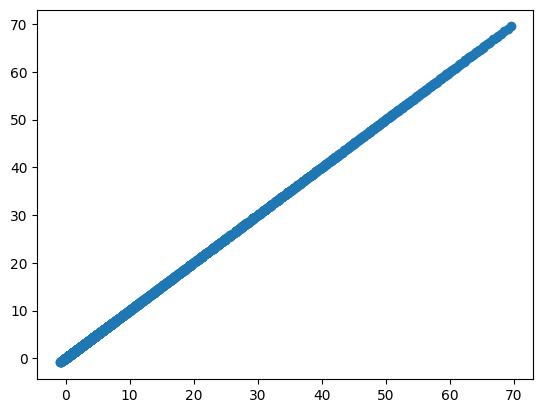

In [17]:

RI_SSD,RI_SAD,Derivatives,Estimates = get_Derivatives(
    'Model',N_models,range_TA_RH.T, grid_VPD.flatten())

for t in [RI_SSD,RI_SAD,Derivatives,Estimates]:
    print(t.shape)
# # grid_VPD.flatten().shape
# print(grid_VPD.flatten().shape)
print(Derivatives.shape)
# print(DH.shape)
print(Estimates.shape)



fig,ax=plt.subplots()
for i in range(1):
    ax.scatter(y_pred[i].flatten(),Estimates[:,i,])
# range_TA_RH.T.shape



## Validation

* The NN ensemble provides comparable fits to the RF model over the training domain.  
* It does a much better job with the data gap example, where the RF performed very poorly.
* It is even capable of extrapolating to make a reasonable guess at VPD even outside the range of Ta that it was trained on.
    * The further outside the training domain, the less accurate predictions will be ... but it does pretty well in this simple example

Test the Full Dataset
208/208 [==============================] - 0s 1ms/step

Validation metrics within training domain: 
r2 =  0.99932 
RMSE =  0.01395  VPD hPa

Test the Masked Dataset
456/456 [==============================] - 1s 2ms/step

Validation metrics within training domain: 
r2 =  0.99867 
RMSE =  0.03685  VPD hPa

Validation metrics for data gap: 
r2 =  0.87373 
RMSE =  0.2565  VPD hPa
79/79 [==============================] - 0s 2ms/step

Validation metrics over wider Ta range (-30 to 50): 
r2 =  0.8845 
RMSE =  52.29059  VPD hPa
Minimum estimated VPD:  -0.89183444
Maximum estimated VPD:  68.59763


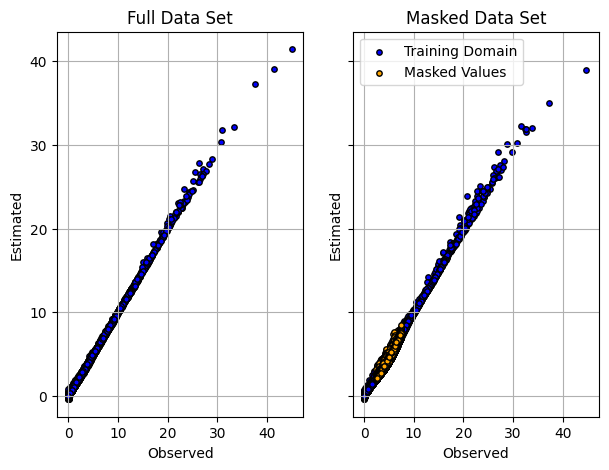

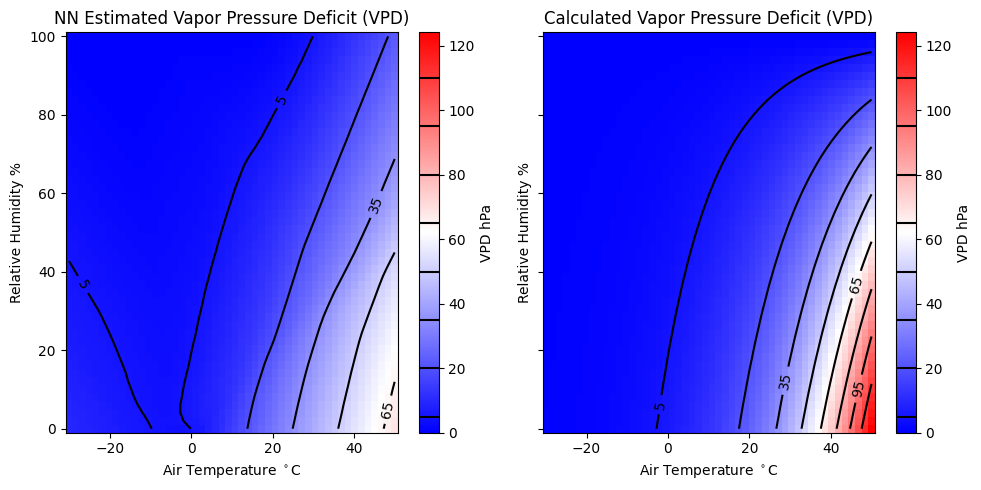

In [18]:
fig,axes=plt.subplots(1,2,figsize=(7,5),sharex=True,sharey=True)

print('Test the Full Dataset')

y_pred = predict_Model('Model',N_models,x_val)

R2 = metrics.r2_score(y_val,y_pred.mean(axis=0))
RMSE = metrics.mean_squared_error(y_val,y_pred.mean(axis=0))
print()
print('Validation metrics within training domain: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

ax = axes[0]
ax.scatter(y_val,y_pred.mean(axis=0),label='Training Domain',color='blue',s=15,edgecolor='k')
ax.set_ylabel('Estimated')
ax.set_xlabel('Observed')
ax.grid()
ax.set_title('Full Data Set')

# Test interpolation capabilities
print()
print('Test the Masked Dataset')

y_pred_mask = predict_Model('Masked_Model',N_models,x_val_mask)
y_fill = predict_Model('Masked_Model',N_models,x_missing)

R2 = metrics.r2_score(y_val_mask,y_pred_mask.mean(axis=0))
RMSE = metrics.mean_squared_error(y_val_mask,y_pred_mask.mean(axis=0))
print()
print('Validation metrics within training domain: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

R2 = metrics.r2_score(y_missing,y_fill.mean(axis=0))
RMSE = metrics.mean_squared_error(y_missing,y_fill.mean(axis=0))
print()
print('Validation metrics for data gap: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

ax = axes[1]
ax.scatter(y_val_mask,y_pred_mask.mean(axis=0),label='Training Domain',color='blue',s=15,edgecolor='k')
ax.set_ylabel('Estimated')
ax.set_xlabel('Observed')
ax.scatter(y_missing,y_fill.mean(axis=0),label='Masked Values',color='orange',s=15,edgecolor='k')
ax.set_title('Masked Data Set')
ax.legend()
ax.grid()

# Test extrapolation capabilities

NN_range_VPD = predict_Model('Model',N_models,range_TA_RH.T)
NN_grid_VPD = NN_range_VPD.mean(axis=0).T.reshape(grid_TA.shape)


R2 = metrics.r2_score(grid_VPD.flatten(),NN_grid_VPD.flatten())
RMSE = metrics.mean_squared_error(grid_VPD.flatten(),NN_grid_VPD.flatten())
print()
print('Validation metrics over wider Ta range (-30 to 50): \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)
        
print('Minimum estimated VPD: ',NN_grid_VPD.min())
print('Maximum estimated VPD: ',NN_grid_VPD.max())


fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
ax = axes[0]
Contour_Plot(ax,grid_TA,grid_RH,NN_grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('NN Estimated Vapor Pressure Deficit (VPD)')

ax = axes[1]
Contour_Plot(ax,grid_TA,grid_RH,grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Calculated Vapor Pressure Deficit (VPD)')
plt.tight_layout()


## Model Inspection

* We can calculate the relative feature importance, as we can with the RF model.  But we can also calculate and plot partial first derivatives with respect to each input, which allows us to see whats going on in the model.  This is much more useful than plotting the individual decision trees, which is the best option for the RF model.
    * Note that the relative importance of the RF model and the NN ensemble are very different 
        - Gevery (2003) who initially proposed this method used the Sum of squared derivatives (SSD).  
        - This many unnecessarily penalize inputs with small (<1), but consistent derivatives, to get around this you can use the sum of absolute derivative (SAD) instead.

ValueError: Shape of passed values is (2, 1), indices imply (2, 2)

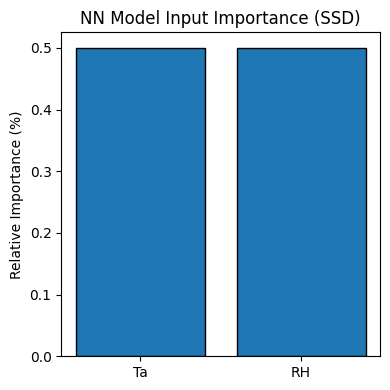

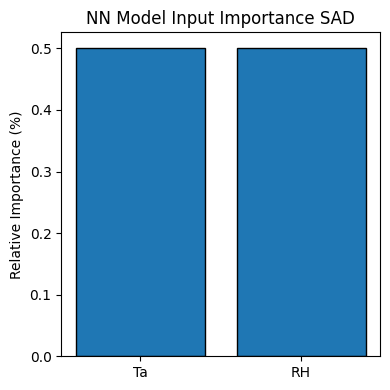

In [20]:
RI_SSD,RI_SAD,Derivatives,Estimates = get_Derivatives('Model',N_models, X_full, Y_full)

RI_mean = RI_SSD.mean(axis=1).mean(axis=-1)
RI_se = RI_SSD.std(axis=1).mean(axis=-1)/RI_SSD.shape[1]**.5

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_vars,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance (%)')
ax.set_title('NN Model Input Importance (SSD)')
plt.tight_layout()


RI_mean = RI_SAD.mean(axis=1).mean(axis=-1)
RI_se = RI_SAD.std(axis=1).mean(axis=-1)/RI_SAD.shape[1]**.5

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_vars,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance (%)')
ax.set_title('NN Model Input Importance SAD')
plt.tight_layout()

Estimates_mean = Estimates.mean(axis=-1).mean(axis=-1)

Model_Derivatives = pd.DataFrame(
    Derivatives.mean(axis=-1).mean(axis=-1).T, columns = ['dVPD_d'+x for x in X_vars])
Model_Derivatives = Model_Derivatives.join(
    pd.DataFrame(Derivatives.mean(axis=-1).std(axis=-1).T/Derivatives.shape[0]**.5, columns = ['dVPD_d'+x+'_se' for x in X_vars])
)
Model_Derivatives['VPD_estimated'] = Estimates_mean#[:,0]
Model_Derivatives['VPD'] = Y_full
Model_Derivatives[X_vars] = X_full

def Plot_Derivs(Derivs,X,dy,ax):
    D = Derivs[[X,dy,dy+'_se']].sort_values(by=X)
    ax.fill_between(D[X],D[dy]-D[dy+'_se'],D[dy]+D[dy+'_se'],
                    facecolor='#1356c240',edgecolor='#1356c2')
    ax.plot(D[X],D[dy],color='r')
    ax.grid()
    ax.set_xlabel(X)

fig,ax = plt.subplots(1,2,figsize = (7,5),sharey=True)
Plot_Derivs(Model_Derivatives,'Ta','dVPD_dTa',ax[0])
Plot_Derivs(Model_Derivatives,'RH','dVPD_dRH',ax[1])
ax[0].set_ylabel('dVPD/dX')
ax[0].set_title('Partial First Derivative (Ta)')
ax[1].set_title('Partial First Derivative (RH)')

plt.tight_layout()

Model_Derivatives.describe().T.round(3)

In [23]:
Derivatives.mean(axis=-1).shape#.mean(axis=-1).T

(2, 66513)